In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL
import os
import time
y = []
chanel_num = 3
r=3 #Upscaling factor

print("Start")
t = time.time()
dir = "D:\\ML\\espcn\\dataset-upload-to-kaggle\\finished\\train\\dataraw\\hires\\" #Your dir
hr_size = 720
data_size = 150
for i in range(1,data_size+1):#This might takes long.
    y_img = plt.imread(dir+'dt_train_'+str(i)+".jpg")[:hr_size,:hr_size]
    if y_img.shape!=(hr_size,hr_size,chanel_num):
        continue
    y.append(y_img.tolist())
    if i%10==0:
        print(i, "/", data_size, "loaded")
y = np.array(y, dtype=np.float32)
print(time.time()-t, "sec")
#Read your data
    



Start
10 / 150 loaded
20 / 150 loaded
30 / 150 loaded
40 / 150 loaded
50 / 150 loaded
60 / 150 loaded
70 / 150 loaded
80 / 150 loaded
90 / 150 loaded
100 / 150 loaded
110 / 150 loaded
120 / 150 loaded
130 / 150 loaded
140 / 150 loaded
150 / 150 loaded
58.301061153411865 sec


In [2]:
input_size = int(y.shape[1]/r)
def sub_extract(data, f_size, stride): #Crop the image
    result = []
    for d in data:
        output_w = 1+(d.shape[1]-f_size)/stride
        output_w = np.int(output_w)
        output_h = 1+(d.shape[0]-f_size)/stride
        output_h = np.int(output_h)
        for y in range(output_h):
            for x in range(output_w):
                sub_d = d[y*stride:y*stride+f_size, x*stride:x*stride+f_size, :]
                result.append(sub_d.tolist())
    result = np.asarray(result)
    return result

def resize(x,output_size):
    x = x.astype(np.uint8)
    img_list = [PIL.Image.fromarray(t) for t in x]
    img_list = [np.asarray(t.resize((output_size, output_size))) for t in img_list]
    img_list = np.asarray(img_list).astype(np.float32)
    return img_list

t = time.time()
x = resize(y, input_size)
x = (x-127.5)/127.5
y = (y-127.5)/127.5 # -1~1

print(time.time()-t, "sec")


1.1972627639770508 sec


x.shape :  (119, 240, 240, 3)
y.shape :  (119, 720, 720, 3)
x_val.shape :  (30, 240, 240, 3)
y_val.shape :  (30, 720, 720, 3)
x_sub.shape :  (30464, 17, 17, 3)
y_sub.shape :  (30464, 51, 51, 3)


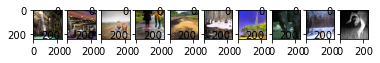

In [3]:
val_size = 30
x_val = x[-val_size:]
y_val = y[-val_size:]
x = x[:-val_size]
y = y[:-val_size]
t = time.time()
x_sub = sub_extract(x, 17, 14)#This might takes long.
y_sub = sub_extract(y, 17*r, 14*r)#This might takes long.
print(time.time()-t, "sec")
print("x.shape : ", x.shape)
print("y.shape : ", y.shape)

print("x_val.shape : ", x_val.shape)
print("y_val.shape : ", y_val.shape)


print("x_sub.shape : ", x_sub.shape)
print("y_sub.shape : ", y_sub.shape)

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow((x_val[i]*127.5+127.5).astype(np.uint8))
    plt.axis('off')
plt.show()

In [20]:

def phase_shift(LR): ##LR (bsize, input_size, input_size, r*r)
    bsize, a, b, no = LR.shape
    LR = tf.reshape(LR, (bsize, a, b, r, r))
    LR = tf.split(LR, a, 1) # (bsize, 1, b, r, r)가 a개인 list 반환
    LR = [tf.squeeze(x) for x in LR] # (bsize, b, r, r)가 a개
    LR = tf.concat(LR, axis=2) # (bsize, b, a*r, r)
    LR = tf.split(LR, b, 1) # (bsize, 1, a*r, r) 가 b개
    LR = [tf.squeeze(x) for x in LR]# (bsize, a*r, r) 가 b개
    LR = tf.concat(LR, axis=2) # (bsize, a*r, b*r)
    LR = tf.reshape(LR, (bsize, a*r, b*r, 1))
    return LR

def PS(T, C, r): # T (bsize, input_size, input_size,r*r*C)
    T = tf.split(T, C, 3)
    T = [phase_shift(x) for x in T] # (C, bsize, a*r, b*r, 1)
    T = tf.concat(T, axis=3) # (bsize, a*r, b*r, C)
    return T

def save_img(image):
    n = 0
    dir = "D:\\ML\\espcn\\save"
    os.makedirs(dir, exist_ok=True)
    for x in image:
        img = x.numpy()*127.5 + 127.5
        img = img.astype(np.uint8)
        im = PIL.Image.fromarray(img.astype('uint8'), 'RGB')
        im.save(dir + str(n) + ".jpg")
        n+=1



model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(input_shape=(None, None, chanel_num),
                           kernel_size=5, filters=64*chanel_num, padding='same', activation='tanh'),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32*chanel_num, padding='same', activation='tanh'),
    tf.keras.layers.Conv2D(kernel_size=3, filters=chanel_num*r*r, padding='same', activation='tanh')

])

def get_grad_loss_hypothesis(x,y):

    with tf.GradientTape() as tape:
        out = model(x)
        hypothesis = PS(out, chanel_num, r)
        loss = tf.reduce_mean(tf.square(hypothesis-y))
    grads = tape.gradient(loss, model.variables)
    return (grads, loss.numpy(), hypothesis)

print("Start")



Start


In [21]:
lr = 0.001
batch_size = 128
batch_num = int(x_sub.shape[0]/batch_size)

history_loss = []
history_val_loss = []

print("batch_num: " , batch_num)

batch_num:  238


In [22]:
total_epoch = 100
for epoch in range(total_epoch+1):
    loss_total = 0
    for batch in range(batch_num):
        X = x_sub[batch*batch_size:(batch+1)*batch_size]
        Y = y_sub[batch*batch_size:(batch+1)*batch_size]
        grads, loss, _ = get_grad_loss_hypothesis(X,Y)
        loss_total+=loss/batch_num
        optimizer = tf.optimizers.Adam(learning_rate=lr)
        optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))
    history_loss.append(loss_total)

    if epoch%1 == 0:
        lr = lr*0.98
        _, loss_val, images = get_grad_loss_hypothesis(x_val[:20], y_val[:20])
        
        print(epoch, "loss_val : ", loss_val)
        images = images.numpy()*127.5+127.5
        images = images.astype(np.uint8)
        history_val_loss.append(loss_val)
        
        for n,img in enumerate(images):
            n+=1
            if n>5:
                break
            plt.subplot(1,5,n)
            plt.imshow(img)
            plt.axis('off')

        plt.show()

    
    


ResourceExhaustedError: OOM when allocating tensor with shape[20,192,240,240] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D]

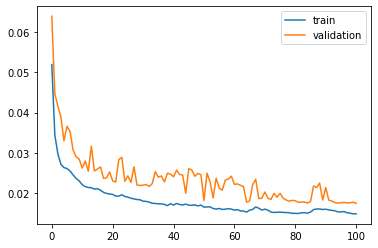

In [9]:
plt.plot(history_loss, label='train')
plt.plot(history_val_loss, label='validation')
plt.legend()
plt.show()


x_test.shape :  (123, 120, 120, 3)
y_test.shape :  (123, 360, 360, 3)
0.013089362376679976


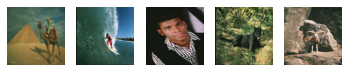

In [10]:
dir = "D:\\ML\\espcn\\test\\" #Your dir
y_test = []
for i in range(123):
    y_img = plt.imread(dir+'y_test'+str(i)+".jpg")
    y_test.append(y_img.tolist())
y_test = np.array(y_test, dtype=np.float32)
#Read your data
    
input_size = int(y_test.shape[1]/r)
    
x_test = resize(y_test, input_size)
x_test = np.array(x_test, dtype=np.float32)
x_test = (x_test-127.5)/127.5
y_test = (y_test-127.5)/127.5 # -1~1

print("x_test.shape : ", x_test.shape)
print("y_test.shape : ", y_test.shape)

batch_size = 20
batch_num = x_test.shape[0]/batch_size
batch_num = int(batch_num)

loss_mean = 0
for batch in range(0,batch_num):
    X = x_test[batch*batch_size:(batch+1)*batch_size]
    Y = y_test[batch*batch_size:(batch+1)*batch_size]
    
    _, loss, hypothesis = get_grad_loss_hypothesis(X,Y)
    loss_mean += loss/batch_num


print(loss_mean)

imgs = hypothesis.numpy()*127.5+127.5
imgs = imgs.astype(np.uint8)

for i,img in enumerate(imgs):
    i+=1
    if i>5:
        break
    plt.subplot(1,5,i)
    plt.imshow(img)
    plt.axis('off')


In [14]:
mask = np.random.choice(range(123), 20, replace=False)

X = x_test[mask]
Y = y_test[mask]

_, __, imgs = get_grad_loss_hypothesis(X,Y)

losses = tf.square(imgs-Y)

def PSNR(loss):
    return 20*np.log10(1/np.sqrt(loss))
psnr_list = []
for i in losses:
    loss_i = tf.reduce_mean(i).numpy()
    psnr_list.append(PSNR(loss_i))
psnr_list = np.array(psnr_list)

print(psnr_list.mean())



19.9606457358506
